### Pytorch.  LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

Я выбрал следующие классы:


 - 0 sitting down
 - 1 standing up (from sitting position)
 - 2 clapping
 - 3 reading
 - 4 writing
 - 5 take off a hat/cap
 - 6 cheer up
 - 7 hand waving
 - 8 jump up

In [ ]:
skeletons = pd.read_csv("/content/drive/My Drive/PyTorch/test_01.csv")

In [ ]:
LABELS = {
    0: "sitting down", 
    1: "standing up", 
    2: "clapping", 
    3: "reading", 
    4: "writing", 
    5: "take off a hat/cap", 
    6: "cheer up", 
    7: "hand waving", 
    8: "jump up"}

In [ ]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3336,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,0.771350,3.486234,-0.164331,0.563798,3.590046,-0.190102,0.352717,3.684158,-0.216094,0.134737,3.713189,-0.213840,0.078266,3.713352,0.055824,0.536555,3.467626,0.093535,0.305820,3.504891,0.066233,0.116072,3.507060,0.051085,0.041107,3.520018,-0.129093,0.140596,3.682804,-0.095307,...,0.125316,-0.082284,3.994426,-0.091925,-0.150032,3.786463,-0.059436,-0.470481,3.933452,-0.015971,-0.536822,3.898054,0.232809,-0.077865,3.950686,0.009806,-0.151474,3.729795,0.049864,-0.455693,3.827238,0.006749,-0.522025,3.745156,0.103563,0.309071,3.770465,-0.037153,-0.219317,3.875848,-0.066586,-0.194186,3.880914,0.103227,-0.183070,3.717531,0.180819,-0.130425,3.724300,0
1,0.224113,-0.031984,4.022326,0.217001,0.177784,3.932267,0.210570,0.384047,3.831980,0.188331,0.497932,3.802332,0.093215,0.312804,3.919903,0.043695,0.095412,3.990293,0.015687,-0.041901,3.864388,0.014977,-0.063312,3.832369,0.303312,0.284615,3.789172,0.313195,0.091174,3.804576,0.198835,-0.115773,3.724540,0.148842,-0.153402,3.706457,0.175363,-0.025939,4.018429,-0.069625,...,-0.015752,0.186064,3.735717,-0.026741,-0.171879,3.820120,0.039023,-0.410326,3.954949,0.040712,-0.513942,3.894690,0.070837,0.168282,3.702682,0.056373,-0.200432,3.748308,0.089038,-0.472481,3.867306,0.058827,-0.566387,3.851228,-0.012763,0.536085,3.509441,-0.095632,0.056224,3.739927,-0.114635,0.082521,3.725400,0.091566,-0.081738,3.656859,0.067479,-0.000107,3.618084,1
2,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,0.769087,3.496161,-0.135204,0.577477,3.618551,-0.133122,0.358243,3.487167,-0.120882,0.534694,3.514019,-0.094348,0.588087,3.538668,0.089661,0.531060,3.476222,0.165636,0.352696,3.504042,-0.065932,0.337171,3.454219,-0.127669,0.346036,3.451911,-0.075961,0.195749,3.667959,-0.064483,...,-0.065839,0.197170,3.664950,-0.058025,-0.141329,3.785261,-0.033219,-0.421956,3.935089,-0.079306,-0.476134,3.845834,0.012280,0.183455,3.615751,0.072281,-0.152907,3.702846,0.074534,-0.468743,3.884177,0.027604,-0.522516,3.794972,0.000309,0.593457,3.544754,-0.267565,0.550163,3.435139,-0.247820,0.496548,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,2
3,0.205810,0.192052,3.810989,0.213430,0.442297,3.726759,0.221343,0.687635,3.632531,0.190760,0.800906,3.606914,0.091805,0.614839,3.709685,0.070733,0.485538,3.835492,0.075981,0.413761,3.604359,0.084202,0.368417,3.539332,0.328296,0.590779,3.601562,0.397093,0.398531,3.637018,0.176298,0.369753,3.554382,0.109567,0.365475,3.549501,0.150665,0.193746,3.799509,0.179800,...,0.156123,0.208811,3.815786,0.189649,-0.108433,3.940452,0.231217,-0.415661,4.092692,0.244529,-0.481803,4.059097,0.259376,0.201769,3.777712,0.302917,-0.115797,3.862270,0.321422,-0.423885,4.006565,0.284749,-0.474948,4.029401,0.225790,0.625955,3.697713,0.231251,0.453419,3.475247,0.218939,0.449263,3.478400,-0.009107,0.534840,3.517180,0.053082,0.530157,3.493546,3
4,0.233268,0.182226,3.738342,0.246664,0.427726,3.664138,0.258953,0.668395,3.579175,0.232204,0.781505,3.551870,0.117728,0.601550,3.670279,0.027383,0.509896,3.821514,0.162564,0.409676,3.584376,0.068962,0.411862,3.408963,0.374092,0.579483,3.550387,0.418521,0.377121,3.579854,0.245717,0.343384,3.455242,0.197204,0.363410,3.468647,0.175561,0.183498,3.725377,0.198265,...,0.168774,0.190261,3.724671,0.196067,-0.134319,3.857288,0.246618,-0.421726,4.010206,0.213246,-0.470665,3.924187,0.275668,0.183728,3.684674,0.316404,-0.131877,3.781667,0.316957,-0.438056,3.959861,0.283030,-0.486836,3.873899,0.226930,0.592966,3.605333,0.362158,0.365421,3.476291,0.341380,0.398297,3.464900,0.086362,0.484182,3.377581,0.137638,0.470977,3.347150,4


## Dataloader

In [ ]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.normalize = self.normalize(self.data)

    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.data.iloc[idx,-1]
        
        if self.transform != None:
            item = self.transform(item)

        return (item, label)


    def normalize(self, data):
        '''Приводит данные к отрезку от 0 до 1'''
        X = data.values
        result = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        return result       

In [ ]:
dataset = Skeleton_Dataset(file_path = "/content/drive/My Drive/PyTorch/test_01.csv", transform=None)

In [ ]:
skel, lab = dataset.__getitem__(41)

In [ ]:
skel

array([[0.38029  , 0.2208916, 3.816976 , ..., 0.4855051, 0.5063214,
        3.4082   ],
       [0.3802876, 0.2208559, 3.816864 , ..., 0.368538 , 0.4338186,
        3.4935   ],
       [0.3805799, 0.2214972, 3.816803 , ..., 0.3224915, 0.4371471,
        3.545334 ],
       ...,
       [0.3770275, 0.2149056, 3.804242 , ..., 0.5289171, 0.4943787,
        3.460667 ],
       [0.3756532, 0.2142559, 3.804005 , ..., 0.5425205, 0.5035607,
        3.43775  ],
       [0.3766641, 0.2112738, 3.805015 , ..., 0.4998489, 0.5147105,
        3.41775  ]])

Данные не нормализованы.




In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.6*len(dataset)+1),int(0.4*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [ ]:
n_hidden = 256
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 3
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 256, num_layers=3, batch_first=True)
  (dr): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.Adam(rnn.parameters(),lr=learning_rate)

all_losses = []
start = time.time()
counter = 0
for epoch in range(60):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 50 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗, the answer is (%s)' % category
            #####сделать более аккуратный вывод для каждой эпохии
            ######сделать обновление графика loss по ходу обучению  
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 50 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 0.1565  / take off a hat/cap ✓
epoch : 1 iter : 3 (0m 3s) 0.6247  / hand waving ✓
epoch : 2 iter : 6 (0m 6s) 0.4090  / jump up ✓
epoch : 3 iter : 9 (0m 9s) 0.3195  / jump up ✓
epoch : 4 iter : 12 (0m 12s) 0.4618  / cheer up ✓
epoch : 5 iter : 15 (0m 16s) 0.1083  / take off a hat/cap ✓
epoch : 6 iter : 18 (0m 19s) 0.2507  / standing up ✓
epoch : 7 iter : 21 (0m 22s) 0.3777  / reading ✓
epoch : 8 iter : 24 (0m 25s) 0.5094  / writing ✗, the answer is (reading)
epoch : 9 iter : 27 (0m 28s) 0.1486  / take off a hat/cap ✓
epoch : 10 iter : 30 (0m 31s) 0.2682  / reading ✓
epoch : 11 iter : 33 (0m 35s) 0.1825  / take off a hat/cap ✓
epoch : 12 iter : 36 (0m 38s) 0.2106  / hand waving ✓
epoch : 13 iter : 39 (0m 41s) 0.1197  / sitting down ✓
epoch : 14 iter : 42 (0m 44s) 0.2721  / take off a hat/cap ✗, the answer is (hand waving)
epoch : 15 iter : 45 (0m 47s) 0.2032  / jump up ✓
epoch : 17 iter : 1 (0m 51s) 0.2100  / standing up ✓
epoch : 18 iter : 4 (0m 54s) 0.2761  /

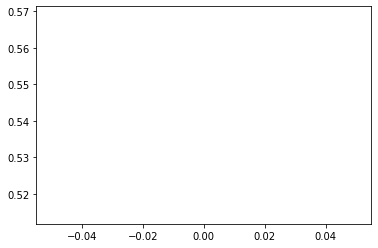

In [ ]:
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [ ]:
total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   83.87096774193549
